# Variational Image Domain Analysis

Imaging is one of the first steps in imaging. After you want to move from image domain to feature domain. By features, we mean image structures that are *interesting*. For example, in the analysis of M87 we were interested in the diameter, width, brightness position angle and asymmetry. 

VIDA is a generic tools specifically designed to work with the EHT and its images. In this notebook we will demonstrate how to use VIDA to extract quantitative image feature estimates from the image you just created.

In [1]:
# This creates a local environment in Julia so you can explore a number of things
using Pkg; Pkg.activate(@__DIR__)

  Activating environment at `~/Research/Projects/ngEHT/ngEHT2021-Tutorial/Project.toml`


In [2]:
# Now lets instiate our environment to match the one used to create this notebook!
Pkg.instantiate()

# If you wanted to add VIDA you could also do
# Pkg.add("VIDA")
# For plots
# Pkg.add("Plots")

In [3]:
# Load the packages
using VIDA
using Plots

## Loading the image and deciding on image features

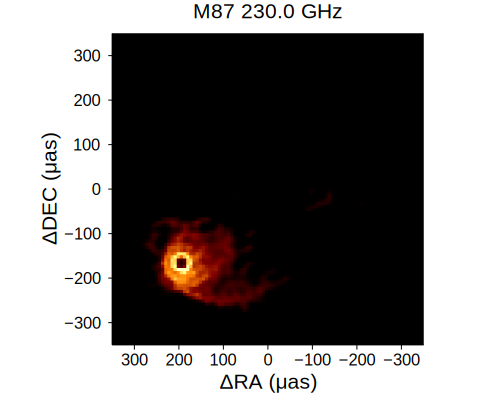

In [6]:
img = load_image("results/M87_ngeht_ref1_230_thnoise.fits")

#Make the image log-scale so we can see the jet base.
plot(log10.(img./flux(img)), clims=(-2200, -500), colorbar=:none)

## Deciding on a template

VIDA is basically a template matching algorithm. Which mean we need to decide on the specific image structure we want to extract. In this image there are two components

1. The ring
2. The jet or larger Gaussian structure

For 1 we will use the `SlashedGaussianRing` template. To see its detail please see the docs or `?` to bring up the docstrings.

For 2 we will use the `AsymGaussian` template. This is a asymmetric Gaussian template. 

Finally we will include a `Constant` filter to deal with the low level diffuse flux the commonly appears in these image reconstructions

To stack templates, VIDA has overloaded the `+` operator to construct a composite model. To construct our template we do:

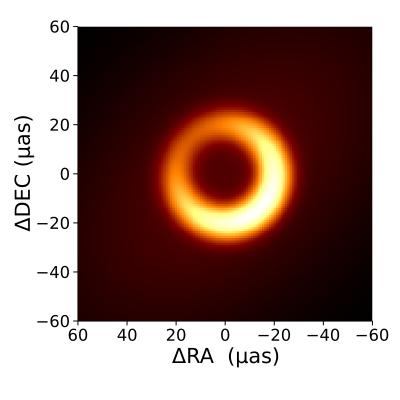

In [7]:
# The ring is rather simple so lets use a 0,2 cosine ring
template = SlashedGaussianRing(r0 = 20.0, #ring radius in μas
                              σ = 5.0, #ring width in μas
                              s = 0.5, # brightness cosine expansion amplitdues
                              ξ = -3π/4, # brightness position angle
                              x0 = 0.0, #ring center in RA
                              y0 = 0.0  #rin center in DEC
                             ) + 
                        0.2*AsymGaussian(σ=50.0, τ=0.4, ξ=-π/4, x0=0.0, y0=0.0) + 0.1*Constant()
# Plots the template
plot(template)

Now let's fit the template! To do this we need to define our boundaries. We will do this by specifying the upper and lower template

In [8]:
upper = SlashedGaussianRing(r0 = 60.0, #ring radius
                              σ = 40.0, #ring width
                              s = 0.99, # brightness cosine expansion amplitdues
                              ξ = 1π, # brightness cosine expansion phases
                              x0 = 300.0,
                              y0 = 300.0
                             ) + 1.0*AsymGaussian(σ=500.0, τ=0.99, ξ=π/2, x0=400.0, y0=400.0) + 0.5*Constant()
lower = SlashedGaussianRing(r0 = 10.0, #ring radius
                              σ = 0.1, #ring width
                              s = 0.01, # brightness cosine expansion amplitdues
                              ξ = -1π, # brightness cosine expansion phases
                              x0 = -300.0,
                              y0 = -300.0
                             ) + 1e-6*AsymGaussian(σ=5.0, τ=0.01, ξ=-π/2, x0=-400.0, y0=-400.0) + 1e-8*Constant()

VIDA.AddTemplate{VIDA.AddTemplate{SlashedGaussianRing, VIDA.MulTemplate{AsymGaussian, Float64}}, VIDA.MulTemplate{Constant, Float64}}(VIDA.AddTemplate{SlashedGaussianRing, VIDA.MulTemplate{AsymGaussian, Float64}}(SlashedGaussianRing
  r0: Float64 10.0
  σ: Float64 0.1
  s: Float64 0.01
  ξ: Float64 -3.141592653589793
  x0: Float64 -300.0
  y0: Float64 -300.0
, VIDA.MulTemplate{AsymGaussian,Float64}
θ: AsymGaussian
  σ: Float64 5.0
  τ: Float64 0.01
  ξ: Float64 -1.5707963267948966
  x0: Float64 -400.0
  y0: Float64 -400.0
Irel: Float64 1.0e-6
), VIDA.MulTemplate{Constant,Float64}
θ: Constant()Irel: Float64 1.0e-8
)

## Selecting the divergence

VIDA uses probability divergences as its cost function. There are a number of different divergences implemented. To see them we can use the `subtypes(VIDA.AbstractDivergence)` method

In [9]:
subtypes(VIDA.AbstractDivergence)

4-element Vector{Any}:
 Bhattacharyya
 KullbackLeibler
 LeastSquares
 Renyi

 For this problem we will use the Bhattacharyya divergence, let's take a look at the docstring

In [10]:
?Bhattacharyya

search: Bhattacharyya



```julia
struct Bhattacharyya{T<:EHTImage, S} <: VIDA.AbstractDivergence
```

Type for the Bhattacharyya divergence. It constructed from an `EHTImage` i.e. data. Additionally to evaluate the divergence we use a functor approach where if θ is your

### Details

This computes the Bhattacharyya divergence which is related to Hellinger distance between two distributions. In fact, they are both minimized at the same point. The Bhattacharyya divergence is defined as

$$
Bh(f_\theta||\hat{I}) = -\log\int \sqrt{f_\theta(x,y)\hat{I}(x,y)}dxdy,
$$

where $\hat{I}$ is defined as the image normalized to unit flux.


In [11]:
bh = Bhattacharyya(img)

Bhattacharyya{EHTImage{Float64, Matrix{Float64}}, Float64}([5.8307343678454174e-8 7.048651867918633e-8 … 4.3387264098439613e-11 2.6057231904058662e-11; 7.051288705744571e-8 8.532831149853831e-8 … 7.050143081054508e-11 4.3308679728756146e-11; … ; 4.366545234888053e-11 7.084820022222649e-11 … 7.209641795655416e-11 4.424505920648843e-11; 2.61821017858045e-11 4.345771894914635e-11 … 4.42302739882524e-11 2.6546686553652826e-11], 0.7629558866636356)

In [12]:
# Now construct the optimization problem

prob = ExtractProblem(bh, template, lower, upper)

# Now find the minimum using the BBO optimizer

#Threaded extractor will split the problem into the number of threads you started julia with
#Since we are using a default IJulia environment this will be single threaded. To use multiple threads
#see this github issue https://github.com/JuliaLang/IJulia.jl/issues/882
opt, divmin = threaded_extractor(4, prob, BBO(;maxevals=25_000))

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 444 evals, 322 steps, improv/step: 0.429 (last = 0.4286), fitness=0.518872014
1.00 secs, 951 evals, 813 steps, improv/step: 0.357 (last = 0.3096), fitness=0.372367700
1.50 secs, 1534 evals, 1396 steps, improv/step: 0.309 (last = 0.2436), fitness=0.272007879
2.00 secs, 2028 evals, 1890 steps, improv/step: 0.292 (last = 0.2429), fitness=0.248583144
2.50 secs, 2606 evals, 2468 steps, improv/step: 0.273 (last = 0.2093), fitness=0.218706319
3.00 secs, 3198 evals, 3060 steps, improv/step: 0.260 (last = 0.2061), fitness=0.199450097
3.50 secs, 3794 evals, 3656 steps, improv/step: 0.254 (last = 0.2215), fitness=0.165147935
4.00 secs, 4193 evals, 4055 steps, improv/step: 0.248 (last = 0.2005), fitness=0.161035181
4.

17.52 secs, 17997 evals, 17841 steps, improv/step: 0.209 (last = 0.2040), fitness=0.051732034
18.02 secs, 18407 evals, 18251 steps, improv/step: 0.209 (last = 0.2146), fitness=0.051208478
18.52 secs, 18804 evals, 18648 steps, improv/step: 0.210 (last = 0.2494), fitness=0.050856929
19.02 secs, 19239 evals, 19083 steps, improv/step: 0.210 (last = 0.2046), fitness=0.050774385
19.52 secs, 19694 evals, 19538 steps, improv/step: 0.210 (last = 0.2264), fitness=0.050774385
20.02 secs, 20173 evals, 20017 steps, improv/step: 0.210 (last = 0.2088), fitness=0.050774385
20.52 secs, 20635 evals, 20480 steps, improv/step: 0.209 (last = 0.1685), fitness=0.050774385
21.02 secs, 21110 evals, 20955 steps, improv/step: 0.209 (last = 0.1979), fitness=0.050728771
21.52 secs, 21667 evals, 21512 steps, improv/step: 0.209 (last = 0.2226), fitness=0.050705459
22.02 secs, 22175 evals, 22020 steps, improv/step: 0.209 (last = 0.1890), fitness=0.050672833
22.52 secs, 22713 evals, 22558 steps, improv/step: 0.209 (la

4.50 secs, 4250 evals, 4119 steps, improv/step: 0.245 (last = 0.2011), fitness=0.162125881
5.00 secs, 4808 evals, 4677 steps, improv/step: 0.244 (last = 0.2330), fitness=0.143405742
5.51 secs, 5347 evals, 5216 steps, improv/step: 0.238 (last = 0.1892), fitness=0.133545394
6.01 secs, 5872 evals, 5741 steps, improv/step: 0.233 (last = 0.1810), fitness=0.130434083
6.51 secs, 6465 evals, 6334 steps, improv/step: 0.228 (last = 0.1821), fitness=0.115713600
7.01 secs, 7079 evals, 6948 steps, improv/step: 0.222 (last = 0.1645), fitness=0.114050996
7.51 secs, 7637 evals, 7506 steps, improv/step: 0.217 (last = 0.1487), fitness=0.108009946
8.01 secs, 8091 evals, 7960 steps, improv/step: 0.215 (last = 0.1872), fitness=0.105610099
8.51 secs, 8614 evals, 8483 steps, improv/step: 0.212 (last = 0.1644), fitness=0.104212687
9.01 secs, 9152 evals, 9021 steps, improv/step: 0.210 (last = 0.1766), fitness=0.101602575
9.51 secs, 9615 evals, 9484 steps, improv/step: 0.209 (last = 0.1836), fitness=0.097410592

(VIDA.AddTemplate{VIDA.AddTemplate{SlashedGaussianRing, VIDA.MulTemplate{AsymGaussian, Float64}}, VIDA.MulTemplate{Constant, Float64}}(VIDA.AddTemplate{SlashedGaussianRing, VIDA.MulTemplate{AsymGaussian, Float64}}(SlashedGaussianRing
  r0: Float64 18.27651653012855
  σ: Float64 2.6936424758026303
  s: Float64 0.5419362444016782
  ξ: Float64 -1.646077382182799
  x0: Float64 192.29952715510555
  y0: Float64 -162.65820516783742
, VIDA.MulTemplate{AsymGaussian,Float64}
θ: AsymGaussian
  σ: Float64 39.5598827126667
  τ: Float64 0.12321103760330125
  ξ: Float64 0.5767057463240701
  x0: Float64 176.97789589903482
  y0: Float64 -173.40459808161546
Irel: Float64 0.040859930858251584
), VIDA.MulTemplate{Constant,Float64}
θ: Constant()Irel: Float64 0.00029152243027069977
), 0.050648607526046156)

Now lets evaluate the results!

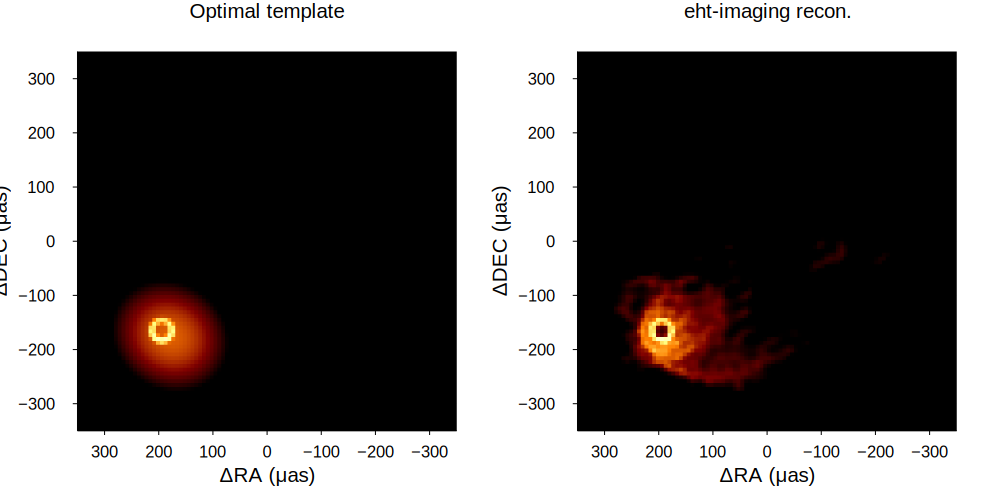

In [13]:
# Create an image object from the optimal template
optimg = VIDA.make_image(opt, 100, (-350, 350), (-350,350))

p1 = plot(log10.(optimg./flux(optimg)), clims=(-2250, -500), colorbar=:none, title="Optimal template")
p2 = plot(log10.(img./flux(img)), clims=(-2250, -500), colorbar=:none, title = "eht-imaging recon.")
plot(p1, p2, layout=(1,2), size=(1000, 500))

Well from that is looks like we are doing a decent job! What are the ring parameters?

In [14]:
# SPlit the template object into components and extract the ring which is the first one
ropt = split(opt)[1]

SlashedGaussianRing
  r0: Float64 18.27651653012855
  σ: Float64 2.6936424758026303
  s: Float64 0.5419362444016782
  ξ: Float64 -1.646077382182799
  x0: Float64 192.29952715510555
  y0: Float64 -162.65820516783742


In [15]:
# Plot just the ring

p1 = plot(optimg./flux(optimg), colorbar=:none, title="Optimal template")
xlims!(p1, ropt.x0-2*ropt.r0, ropt.x0+2*ropt.r0)
ylims!(p1, ropt.y0-2*ropt.r0, ropt.y0+2*ropt.r0)

p2 = plot(img./flux(img), colorbar=:none, title = "eht-imaging recon.")
xlims!(p2, ropt.x0-2*ropt.r0, ropt.x0+2*ropt.r0)
ylims!(p2, ropt.y0-2*ropt.r0, ropt.y0+2*ropt.r0)

plot(p1, p2, layout=(1,2), size=(1000, 500))


## Bonus what happens when we fit two Gaussians?

In [16]:
template2 = template + 0.2*AsymGaussian(σ=50.0, τ=0.4, ξ=-π/4, x0=0.0, y0=0.0)
upper2    = upper   + 1.0*AsymGaussian(σ=500.0, τ=0.99, ξ=π/2, x0=400.0, y0=400.0)
lower2    = lower    + 1e-6*AsymGaussian(σ=5.0, τ=0.01, ξ=-π/2, x0=-400.0, y0=-400.0)

prob2 = ExtractProblem(bh, template2, lower2, upper2);

In [17]:
opt2, divmin2 = extractor(prob2, BBO(;maxevals=50_000, tracemode=:silent))

(VIDA.AddTemplate{VIDA.AddTemplate{VIDA.AddTemplate{SlashedGaussianRing, VIDA.MulTemplate{AsymGaussian, Float64}}, VIDA.MulTemplate{Constant, Float64}}, VIDA.MulTemplate{AsymGaussian, Float64}}(VIDA.AddTemplate{VIDA.AddTemplate{SlashedGaussianRing, VIDA.MulTemplate{AsymGaussian, Float64}}, VIDA.MulTemplate{Constant, Float64}}(VIDA.AddTemplate{SlashedGaussianRing, VIDA.MulTemplate{AsymGaussian, Float64}}(SlashedGaussianRing
  r0: Float64 18.23599293524019
  σ: Float64 2.7057175811832543
  s: Float64 0.4706066854013602
  ξ: Float64 -1.714976681221818
  x0: Float64 192.27784065320787
  y0: Float64 -162.504409409031
, VIDA.MulTemplate{AsymGaussian,Float64}
θ: AsymGaussian
  σ: Float64 54.70956374915185
  τ: Float64 0.3262034859213408
  ξ: Float64 0.5248085268609025
  x0: Float64 151.3477353522604
  y0: Float64 -161.02370564795794
Irel: Float64 0.01459708161886142
), VIDA.MulTemplate{Constant,Float64}
θ: Constant()Irel: Float64 0.00025936042209797683
), VIDA.MulTemplate{AsymGaussian,Float64

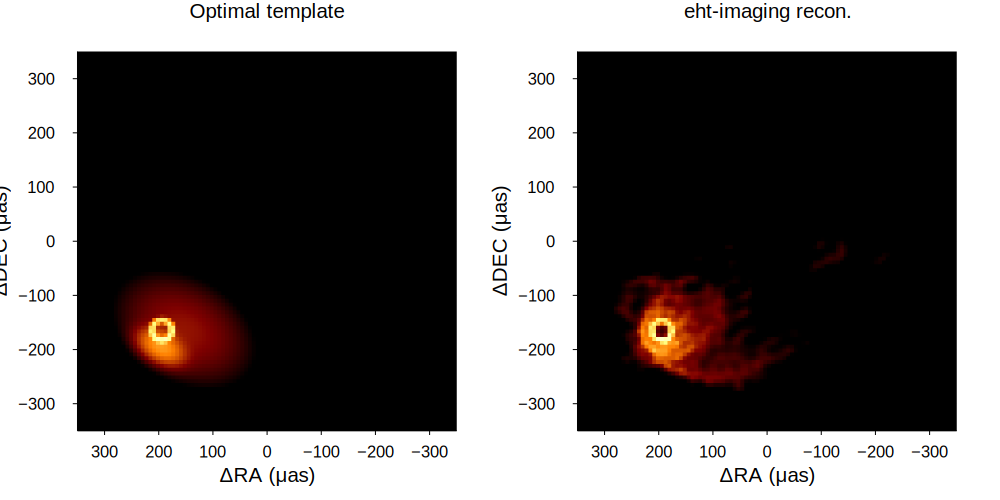

In [18]:
# Create an image object from the optimal template
optimg = VIDA.make_image(opt2, 100, (-350, 350), (-350,350))

p1 = plot(log10.(optimg./flux(optimg)), clims=(-2250, -500), colorbar=:none, title="Optimal template")
p2 = plot(log10.(img./flux(img)), clims=(-2250, -500), colorbar=:none, title = "eht-imaging recon.")
plot(p1, p2, layout=(1,2), size=(1000, 500))